In [1]:
#!pip install evaluate peft==0.10.0 transformers==4.36.0 accelerate==0.28.0

import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import CvtForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    labels = dataset.targets
    for idx, label in enumerate(labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = CvtForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/cvt-21",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.CIFAR10(root="./datasets", download=True, train=True)
test_dataset = datasets.CIFAR10(root="./datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

print(f"CIFAR10 클래스: {classes}")
print(f"클래스 수: {len(classes)}")

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

print(f"학습 데이터 크기: {len(subset_train_dataset)}")
print(f"테스트 데이터 크기: {len(subset_test_dataset)}")

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21"
)

# CIFAR10용 변환 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(
        size=(
            image_processor.size["shortest_edge"],
            image_processor.size["shortest_edge"]
        )
    ),
    
    transforms.Normalize(
        mean=image_processor.image_mean,
        std=image_processor.image_std
    )
])

args = TrainingArguments(
    output_dir="./models/CvT-CIFAR10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
2025-06-18 13:53:24.995995: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 13:53:25.004930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin c

CIFAR10 클래스: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
클래스 수: 10
학습 데이터 크기: 10000
테스트 데이터 크기: 1000


/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
Some weights of CvtForImageClassification were not initialized from the model checkpoin

Epoch,Training Loss,Validation Loss,F1
1,0.805200,0.315930,0.904773
2,0.630800,0.207533,0.930983
3,0.580100,0.195211,0.938852


Checkpoint destination directory ./models/CvT-CIFAR10/checkpoint-625 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./models/CvT-CIFAR10/checkpoint-1250 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./models/CvT-CIFAR10/checkpoint-1875 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1875, training_loss=0.8050073201497396, metrics={'train_runtime': 183.5779, 'train_samples_per_second': 163.418, 'train_steps_per_second': 10.214, 'total_flos': 8.4649093853184e+17, 'train_loss': 0.8050073201497396, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 3.2746265 , -2.4794083 ,  1.4807227 , ..., -1.4223516 ,
         0.6303506 , -2.8533509 ],
       [ 8.837719  , -3.3933678 , -0.5736041 , ...,  1.1971911 ,
        -0.2617984 , -0.9891904 ],
       [ 8.918968  , -2.3696516 , -0.12620078, ..., -0.73055935,
         0.46871972, -0.6442644 ],
       ...,
       [-0.15599875,  0.8246601 , -1.1337376 , ...,  0.92912745,
         0.12712063,  9.479714  ],
       [-1.6016037 , -0.405984  , -0.8344633 , ..., -0.21525055,
        -0.48322326,  4.1527367 ],
       [-2.388456  ,  0.75672466, -1.2794868 , ..., -0.22454655,
         0.09029286,  4.974817  ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

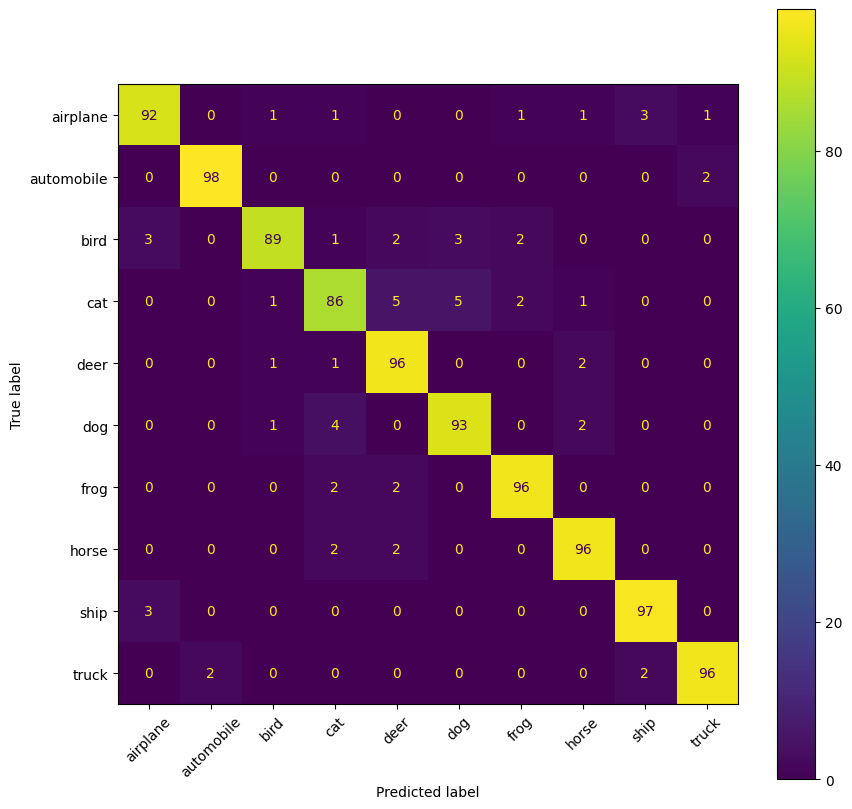

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()

In [3]:
def visualize_predictions(dataset, y_true, y_pred, classes, num_images_per_class=5):
    class_to_images = defaultdict(list)

    # 클래스별로 예시 이미지 수집
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        if len(class_to_images[true]) < num_images_per_class:
            class_to_images[true].append((i, true, pred))

    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_images_per_class, figsize=(num_images_per_class * 2, num_classes * 2))
    fig.suptitle("Prediction Visualization(True → Pred)", fontsize=16)

    for class_idx in range(num_classes):
        images_info = class_to_images[class_idx]
        for j in range(num_images_per_class):
            ax = axs[class_idx, j]
            ax.axis('off')
            if j < len(images_info):
                idx, true, pred = images_info[j]
                image, _ = dataset[idx]

                image = transforms.ToTensor()(image)
                image = image.permute(1, 2, 0).numpy()

                ax.imshow(image)
                title = f"{classes[true]} ({classes[pred]})"
                color = "green" if true == pred else "red"
                ax.set_title(title, color=color, fontsize=8)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


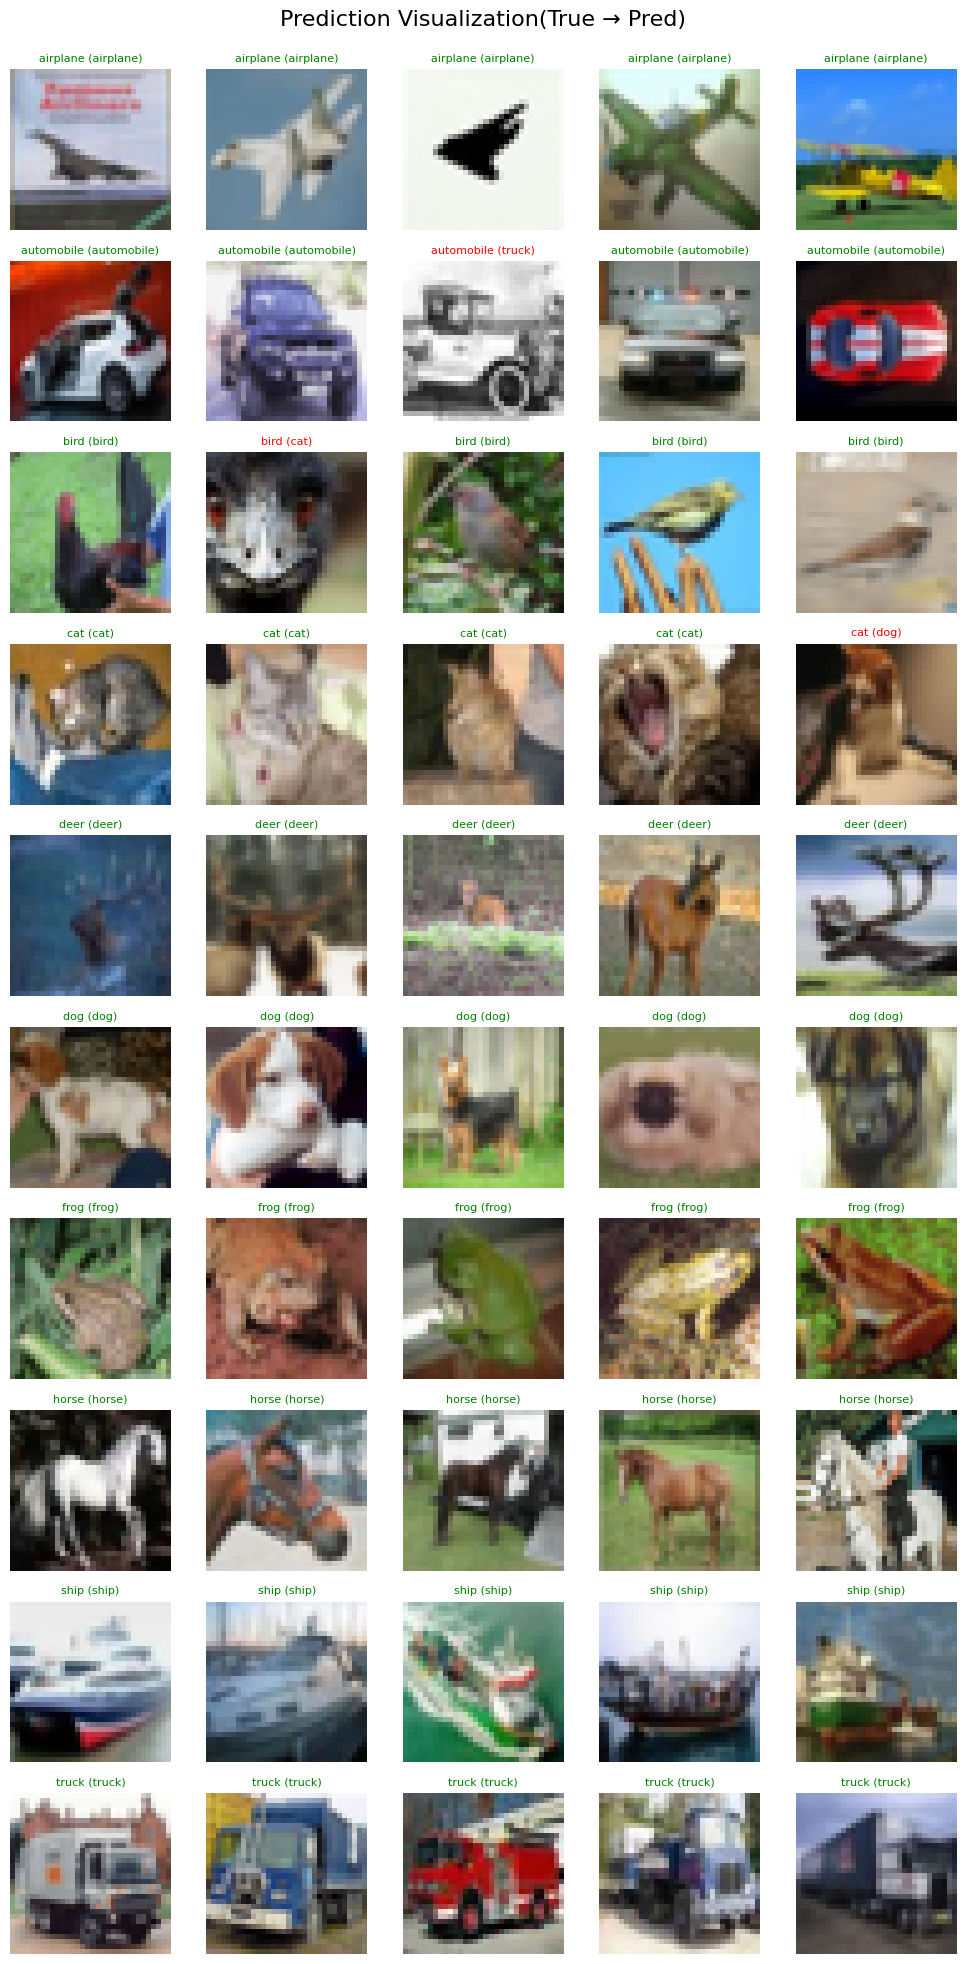

In [4]:
visualize_predictions(subset_test_dataset, y_true, y_pred, classes)
